In [1]:
cd ../../

/mnt/sda/otani/Experiments/hidden-challenges-MR


In [2]:
from src import settings
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src import settings
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.data_converters import ActivityNetCap2Instances
from src.toolbox.visualization import plot_performance_per_duration
import seaborn as sns
import json
import pickle as pkl
from multiprocessing import Pool, cpu_count, Queue
import multiprocessing as mp
import neptune
sns.set_style("white")

In [3]:
raw_data = json.load(open("data/raw/activitynet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [4]:
# download result files from neptune project
# you can also download file manually

project = neptune.init("mayu-ot/moment-retrieval")

if not os.path.exists(f"tmp/MOM-48/TAN_c3d_test.pkl"):
    exps = project.get_experiments(id="MOM-48")
    print("downloading results ...")
    exps[0].download_artifact("TAN_c3d_test.pkl", "tmp/MOM-48/")
    print("done!")

if not os.path.exists(f"tmp/MOM-50/TAN_c3d_test.pkl"):
    exps = project.get_experiments(id="MOM-50")
    print("downloading results ...")
    exps[0].download_artifact("TAN_c3d_test.pkl", "tmp/MOM-50/")
    print("done!")

In [5]:
def postproc_prediction(predictions):
    preds = []
    for p in tqdm(predictions, desc="postproc"):
        query = p[0][0], p[0][1]
        seg = p[1]
        keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
        seg = [seg[i] for i in keep]
        preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
    return preds

def eval_preds(pred_file):
    print(f"loading prediction file {pred_file}")
    predictions = pkl.load(open(pred_file, "rb"))
    preds = postproc_prediction(predictions)
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

results, summary = eval_preds("tmp/MOM-48/TAN_c3d_test.pkl")
randomized_results, randomized_summary = eval_preds("tmp/MOM-50/TAN_c3d_test.pkl")

loading prediction file tmp/MOM-48/TAN_c3d_test.pkl


evaluating: 100%|██████████| 17031/17031 [00:13<00:00, 1278.67it/s]


R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62
loading prediction file tmp/MOM-50/TAN_c3d_test.pkl


evaluating: 100%|██████████| 17031/17031 [00:12<00:00, 1316.03it/s]


R@1 IoU>0.3 0.58
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.76
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.85
R@10 IoU>0.5 0.76
R@10 IoU>0.7 0.62


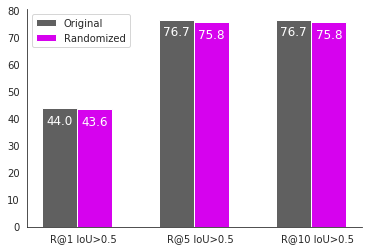

In [6]:
# The performances of the 2D-TAN model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
def plot_performance_comparison(sum_a, sum_b, labels):
    plt.figure(figsize=(6, 4))
    c = ["#606060", "#d602ee"]
    keys = [f"R@{k} IoU>0.5" for k in [1, 5, 10]]
    x = np.arange(3)+0.2
    for score_summary, l in zip([sum_a, sum_b], labels):
        vals = [score_summary[k] * 100 for k in keys]
        bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=l)
        for b in bars:
            display_score(b, color="w")
        x += 0.3

    plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    plt.legend()
    sns.despine(left=False)

plot_performance_comparison(summary, randomized_summary, labels = ["Original", "Randomized"])

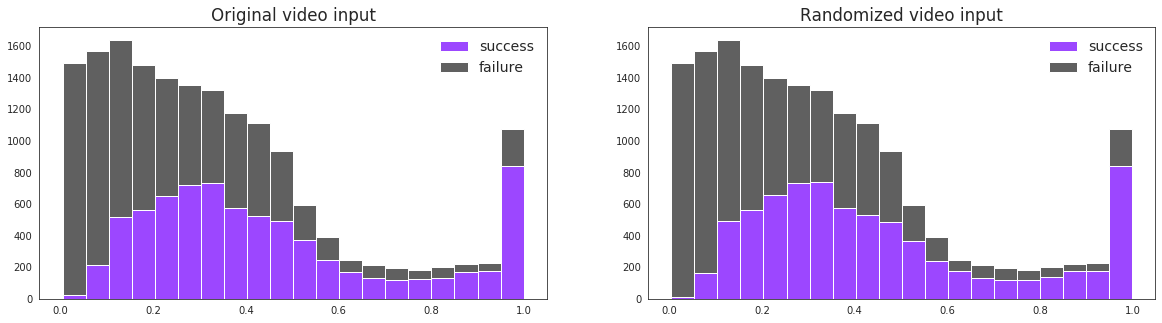

In [7]:
# Check relation between success rates and iput video durations
def plot_comparison_per_duration(results, titles, data):
    f, axes = plt.subplots(1, len(results), figsize=(20, 5))
    plt.rcParams.update({'font.size': 14})
    
    for ax, res, t in zip(axes, results, titles):
        _ = plot_performance_per_duration(res, data, ax=ax)
        ax.set_title(t)


plot_comparison_per_duration(
    (results, randomized_results), 
    ["Original video input", "Randomized video input"],
    test_data)